<a href="https://colab.research.google.com/github/szhou12/gpt-from-scratch/blob/main/gpt_dev_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPT From Scratch
## Resources
- [Let's build GPT: from scratch, in code, spelled out.](https://www.youtube.com/watch?v=kCc8FmEb1nY&ab_channel=AndrejKarpathy)
- [Andrej Karpathy《从零开始搭建GPT|Let's build GPT from scratch, in code, spelled out》中英字](https://www.bilibili.com/video/BV1v4421c7fr/?spm_id_from=333.337.search-card.all.click&vd_source=0c02ef6f6e7a2b0959d7dd28e9e49da4)
- [Illustrated Guide to Transformers Neural Network: A step by step explanation](https://www.youtube.com/watch?v=4Bdc55j80l8&list=LL&index=7&ab_channel=TheAIHacker): Good for a quick walkthrough of GPT Review

In [ ]:
# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-04-01 08:50:32--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.05s   

2024-04-01 08:50:32 (19.9 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [ ]:
# read text data in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
  text = f.read()

In [ ]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1115394


In [ ]:
# let's look at the first 1,000 chars
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [ ]:
# Get all the unique characters that occur in the text
## set(text): make the set of all unique chars in text data
## list(...): to have some ordering so that we can sort it
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


## Tokenize [00:09:30]
- Tokenization: to convert the raw text as string into some sequences of integers according to some notebooks/rules/vocabularies of elements (字符串转换成数字序列的mapping过程).
- 下面给出的例子中, tokenization rule就是根据每个字符对应的index来进行编码.
- 常用的Tokenization方法:
  1. Byte-Pair Encoding (BPE)
    - [Byte-Pair Encoding tokenization - Hugging Face NLP Course](https://huggingface.co/learn/nlp-course/en/chapter6/5)
  2. SentencePiece by Google
  3. tiktoken by OpenAI
- One important Observation: trade-off between codebook size and sequence length.
  - The smaller the vobabulary size, the longer the sequences of integers.
    - e.g. character level vocab is small, so the encoded seq of ints will be long. (shown below)
  - The larger the vobabulary size, the shorter the sequences of integers.
    - e.g. sub-word level vocab is large, so the encoded seq of ints will be short.

In [ ]:
# create a mapping from characters to integers
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [ ]:
# let's now encode the entire text dataset and store it into a torch.Tensor
import torch
data = torch.tensor(encode(text), dtype=torch.long) # 1-D list
print(data.shape, data.dtype)
print(data[:1000]) # show first 1000 characters we looked at earlier

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      

## Train & Test Split [00:13:42]

In [ ]:
# let's now split up the data into train and validation sets
n = int(0.9 * len(data)) # first 90% chars will be train, rest val
train_data = data[:n]
val_data = data[n:] # use val set to get a sense of overfitting

## Train On Chunks [00:14:28]
- **Important thing to notice**:
  1. we'll never feed the entire text into the transformer all at once because it's computationally expensive.
  2. We only feed chunks of the text.
  3. Ramdomly sampling chunks from the text dataset and train on a chunk at a time.
  4. These chunks will be pre-set with max length (normally called `block_size` or `context_length`).

In [ ]:
# set block_size = 8
block_size = 8
train_data[:block_size+1] # first 9 chars. Do you understand why 9 intead of 8?

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

- How many training examples are there in this sequence of integers of length=9?
  - 8 examples!!!
   - Because to predict `i`-th position's char (called "target"), we need to use all `[0:i-1]` positions' chars (called "context"). i.e. one example = `[0:i-1]` predict `[i]`
  - [18] predicts 47, [18, 47] predict 56, [18, 47, 56] predict 58, ...
  - The code below illustrate this concept:

In [ ]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"Round {t}: when input (aka. context) is {context}, the target: {target}")

Round 0: when input (aka. context) is tensor([18]), the target: 47
Round 1: when input (aka. context) is tensor([18, 47]), the target: 56
Round 2: when input (aka. context) is tensor([18, 47, 56]), the target: 57
Round 3: when input (aka. context) is tensor([18, 47, 56, 57]), the target: 58
Round 4: when input (aka. context) is tensor([18, 47, 56, 57, 58]), the target: 1
Round 5: when input (aka. context) is tensor([18, 47, 56, 57, 58,  1]), the target: 15
Round 6: when input (aka. context) is tensor([18, 47, 56, 57, 58,  1, 15]), the target: 47
Round 7: when input (aka. context) is tensor([18, 47, 56, 57, 58,  1, 15, 47]), the target: 58


- **One More Important Thing**
  - Why, for a given block size (=8 in this exmaple), we train from context length of 1 all the way up to context length of block_size (=8)?
  - Not only for computational efficiency;
  - But in order for the transformer to be used to seeing context from as little as length 1 all the way to block size. That is, we want the transformer to be used to all these context lengths (1, 2, 3, ..., 8).
    - Why? Because doing so is useful for later inference.
    - How so? Because while we start sampling, we can start the sampling generation with context length = 1. The transformer will know how to predict in this situation. Similarly, the transformer will how how to predict in the situation of context length = `2, 3, ..., block_size`.
    - 简言之，让模型习惯应对任意长度(`1,2,3, ..., block_size`)的输入情况下的预测。

## Batch dimension [00:18:07]
- Notice that, so far, the tensor is 1-D (call it "time dimension").
- Now onto batch dimension! Every time of sampling, we retreive a batch of chunks instead of one chunk, and feed this batch (multiple chunks) into the transformer all at once at the same time.
- Why? Mainly for computational efficiency. Because GPU is good at parallel processing of data.
- But notice! Each chunk from the batch is processed independently! They don't talk to each other!

In [ ]:
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we parallelly process in every forward-backward pass in the transformer?
block_size = 8 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs X and targets y
    data = train_data if split == "train" else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,)) # 从[0, n-block_size)中随机抽4个数，返回长度为4的list [a, b, c, d]. (batch_size=4,)输出1-D list
    x = torch.stack([data[i:i+block_size] for i in ix]) # X
    y = torch.stack([data[i+1:i+block_size+1] for i in ix]) # true y - used to calculate loss y - y_hat
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)
print('----')

for b in range(batch_size):
    for t in range(block_size):
        context = xb[b, :t+1]
        target = yb[b, t]
        print(f"when input is {context.tolist()} the target: {target}")

inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
----
when input is [24] the target: 43
when input is [24, 43] the target: 58
when input is [24, 43, 58] the target: 5
when input is [24, 43, 58, 5] the target: 57
when input is [24, 43, 58, 5, 57] the target: 1
when input is [24, 43, 58, 5, 57, 1] the target: 46
when input is [24, 43, 58, 5, 57, 1, 46] the target: 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target: 39
when input is [44] the target: 53
when input is [44, 53] the target: 56
when input is [44, 53, 56] the target: 1
when input is [44, 53, 56, 1] the target: 58
when input is [44, 53, 56, 1, 58] the target: 46
when input is [44, 53

## Feeding Data to Neural Network - Bigram Language Model [00:22:14]
- Start with a simple neural network: Bi-gram language model (details in his previous courses)

### Pytorch Recap
1. `import torch.nn as nn`
    - The `torch.nn` module contains classes and functions that are used for building neural networks in PyTorch. This includes the foundational building blocks for neural networks, such as layers (e.g., `Linear`, `Conv2d`), and modules (`Module`), which are the base class for all neural network modules.
    - `nn` (Object-oriented API): Provides classes that allow you to encapsulate parameters and helpers in objects. This is useful for defining complex models and is typically preferred when designing architectures.
2. `from torch.nn import functional as F`
    - The `torch.nn.functional` module contains function versions of many of the operations and layers available in `torch.nn`.
    - These functions include activation functions (`F.relu`, `F.sigmoid`), operations used in convolutional neural networks (`F.conv2d`, `F.max_pool2d`), and loss functions (`F.cross_entropy`), among others.
    - Unlike the classes in `torch.nn`, which require creating an instance of the class (e.g., `layer = nn.Conv2d(...)`), functions in `torch.nn.functional` can be used directly by passing inputs and any necessary parameters (e.g., `output = F.conv2d(input, weight)`).
    - `F` (Functional API): Provides stateless, functional alternatives to the classes in `nn`. This is useful for operations that don't require storing state (parameters), such as applying activations, performing a convolution operation with dynamically created filters, or applying a loss function directly within the model's forward method.
3. `nn.Embedding`
    - A PyTorch layer that's typically used to convert token indices in a vocabulary into dense vector representations (embeddings). The layer takes two main arguments: **(the number of embeddings, the dimensionality of each embedding vector)**. In most natural language processing (NLP) tasks, the dimensionality of embeddings is much smaller than the vocabulary size, facilitating efficient representation of words or tokens.
    - Assume `vocab_size=65`, This layer (`self.token_embedding_table`) now acts as a 65x65 table where **each row corresponds to a token** and **each column to a possible next token**, **with values being the logits** (raw predictions prior to normalization).
    - When you input an index (or indices) to this layer, it returns the corresponding row(s) (aka. channel) from the table. For instance, if the input index is 3 (for `a`), the layer returns the 4th row (0-indexed) of the table, which is a vector of size 65. Each element of this vector represents the model's logit for the probability of each vocabulary token being the next token after `a`.
4. Why Use Cross-Entropy For Loss?
    - Recall cross-entropy measures the difference between two probability distributions.

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        # each token direclty reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):
        '''
        idx: (B,T) tensor of integer. data. xb from previous cell
        targets (Optional): (B,T) tensor of integer. true y. yb from previous cell. Make it optional as generate() won't use loss.
        '''

        # idx and targets are both (B, T) tensor of integers
        # 相当于, 根据idx对应的输入抽出所有下一个token可能出现的概率, 所有下一个token称为channel, 长度为vocab_size
        logits = self.token_embedding_table(idx) # (B,T,C) = (batch, time, channel/class=vocab_size)

        if targets is None:
            loss = None
        else:
            # 进行维度的转换，因为Pytorch中cross_entropy()的第二个param只能接收C, 保留原来的(B,T,C)会报错
            B, T, C = logits.shape
            logits = logits.view(B*T, C) # squash first 2 dims into 1 dim, keep the 3rd dim
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        '''
        idx: (B, T) array of indices in the current context.
            Note! indices meant here are integer representations of chars, so essentially idx are data (context) we feed
        max_new_tokens: # of new tokens to be predicted and appended to idx
        '''
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions (logits)
            logits, loss = self(idx) # self(idx) calls forward()

            # focus only on the last time step
            # -1意味着我们现在只在意用8个token一起predict的那个example
            # 注意: logits[:, i, :] ith位子上的logit表示用前i个token一起predict下一个可能出现的token
            # e.g. 1st logit是只用第一个token predict的结果, 2nd logit是用头两个token predict的结果, 依此类推.
            # -1表示最后一个位子上的logit, 用了所有前面能用到的token
            # !!!上面的理解错了!!!
            # Bigram model中: -1意味着我们现在只用最后一个token来predict下一个token, 没有用到再往前的tokens!
            # 注意: logits[:, i, :] ith位子上的logit表示用第i个token来predict下一个可能出现的token
            # e.g. 1st logit是只用第一个token predict的结果, 2nd logit只用第二个token predict的结果, 依此类推.
            # -1表示最后一个位子上的logit, 只用了所有最后一个token
            logits = logits[:, -1, :] # becomes (B, C)

            # apply softmax to get the probablities
            # dim=-1: 沿着last dimension of logits (ie. C)计算softmax score
            # 每条data, 横向地沿着所有classes计算softmax. 这样，batch中每一条data都独立计算
            probs = F.softmax(logits, dim=-1) # (B, C)

            # sample from the distribution
            # 每条data, 根据class probabilities随机采样一个class.
            # e.g. 假设一条data的probability: [0.1, 0.2, 0.5, 0.3], multinomial根据每个class的概率大小抽一个class (num_samples=1)
            # 显然, i=2的元素最容易抽到因为它的概率最高=0.5
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)

            # append sampled index to the running sequence
            # dim=1 沿着第二个dimension (sequence length dimension)，一列一列地append新的采样到的data
            # [[24, 43], -> [[24, 43, 58],
            #  [52, 58]] ->  [52, 58,  1]]
            # 注意！这里可以直接append index, 是因为tokenization是index直接对应char. 如果是其他tokenize方法, 可能需要额外转换index对应的元素
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)

        return idx



# 1. instantiate BigramLanguageModel class;
# 2. init token_embedding_table as an embedding layer, with logits randomly generated
m = BigramLanguageModel(vocab_size)

logits, loss = m(xb, yb)
print(logits.shape)
print(loss)

# Given [[0]] (1 batch, 1 time step), sequentially generate 100 tokens after first token: [[0]] -> [[0, 1]] -> [[0, 1, 3]] -> ...
# Remember, in this case, each token newly generated uses ONLY ONE token generated ahead of it. NO HISTORY USED HERE! Can you recall why?
# [0].tolist(): take out the content of the first data from the batch and convert it to list
print(decode(m.generate(idx = torch.zeros((1,1), dtype=torch.long), max_new_tokens=100)[0].tolist()))

torch.Size([32, 65])
tensor(4.8786, grad_fn=<NllLossBackward0>)

Sr?qP-QWktXoL&jLDJgOLVz'RIoDqHdhsV&vLLxatjscMpwLERSPyao.qfzs$Ys$zF-w,;eEkzxjgCKFChs!iWW.ObzDnxA Ms$3


## Train The Bigram Language Model [0:34:50]



1. `AdamW`: A variant of the Adam optimizer that decouples the weight decay from the optimization steps. Currently a popular choice of optimizer.
2. `lr=1e-3`: Typically, a good learning rate = `3e-4`. But if you're using small models, you can use higher learning rate.

In [ ]:
# create a PyTorch optimizer
##
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

The code below provides a template of training:
1. `optimizer.zero_grad(set_to_none=True)`: **Zeroing the Gradients**. Clear out the gradients from the previous training step before using optimizer to update the model parameters by this round's gradients. In Pytorch, the gradients are accumulated through training steps!
    - `set_to_none=True`: aims to improve the speed of setting gradients to zero. Traditional way is `optimizer.zero_grad()`, which iterates through all model params' `.grad` attributes and set to zero. Instead of filling zeros, `set_to_none=True` sets `.grad` to `None`. Two advantages: 1) It reduces memory usage 因为不需要内存来暂时储存0. 2) It can potentially speed up gradient zeroing 因为设为None比填充0快一些
2. `loss.backward()`: computes the gradient of the loss w.r.t the model parameters using backpropagation.
3. `optimizer.step()`: updates the model parameters based on the gradients calculated. Update rule depends on the optimizer choice (In this case is `AdamW`).
4. `loss.item()`: `.item()` method converts the loss from a tensor to a Python scalar.

In [ ]:
batch_size = 32

iters = 100 # increase # of steps for better results
for steps in range(iters):
    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = m(xb, yb) # Forward pass + Loss
    optimizer.zero_grad(set_to_none=True) # clear out previous gradient
    loss.backward() # Gradient
    optimizer.step() # Update w

print(loss.item())

4.587916374206543


### Demo of Typical Training Process
- Model: a very simple neural network on a regression task $y = wx + b$.
- Parameters: $w$ and $b$ (bias). Initially, $w=0$, $b=0$. Assume $b=0$ throughout the training.
- Loss Function: $L = (y-\widehat{y})^{2}$ (MSE)
- Learning Rate: $lr = 0.01$
- Dataset: $(x_1=2, y_1=4)$, $(x_2=3, y_2=6)$

1. First step of training using $(x_1=2, y_1=4)$:
    1. Forward pass: $\widehat{y_1} = w⋅x_1 = 0⋅2 = 0$
    2. Loss: $L_1 = (y_1-\widehat{y_1})^{2} = (4-0)^2 = 16$
    3. Gradient: $\frac{dL_1}{dw} = 2⋅(y_1-\widehat{y_1})⋅(-x_1) = 2⋅(4-0)\cdot(-2) = -16$
    4. Update $w$: $w=w-lr⋅\frac{dL_1}{dw} = 0-0.01⋅(-16)=0.16$
2. Second step of training using $(x_2=3, y_2=6)$:
    1. Forward pass: $\widehat{y_2} = w⋅x_2 = 0.16⋅3 = 0.48$
    2. Loss: $L_2 = (y_2-\widehat{y_2})^{2} = (6-0.48)^2$
    3. Gradient: $\frac{dL_2}{dw} = 2⋅(y_2-\widehat{y_2})⋅(-x_2) = 2⋅(6-0.48)⋅(-3) = -33.12$
        - Note: here we clear out step 1's gradient so that we use  $\frac{dL_2}{dw}$ instead of $\frac{dL_2}{dw}+\frac{dL_1}{dw}$!!!
    4. Update $w$: $w=w-lr⋅\frac{dL_2}{dw} = 0.16-0.01⋅(-33.12)=0.4912$

### Recap: Geometric Meaning of Gradient Descent
- Why do we take minus? $w' = w - lr\cdot \frac{dL}{dw}$
    - Because a gradient means the direction of the steepest **increase** of the loss function, we take the opposite value of the gradient to minimize the loss.

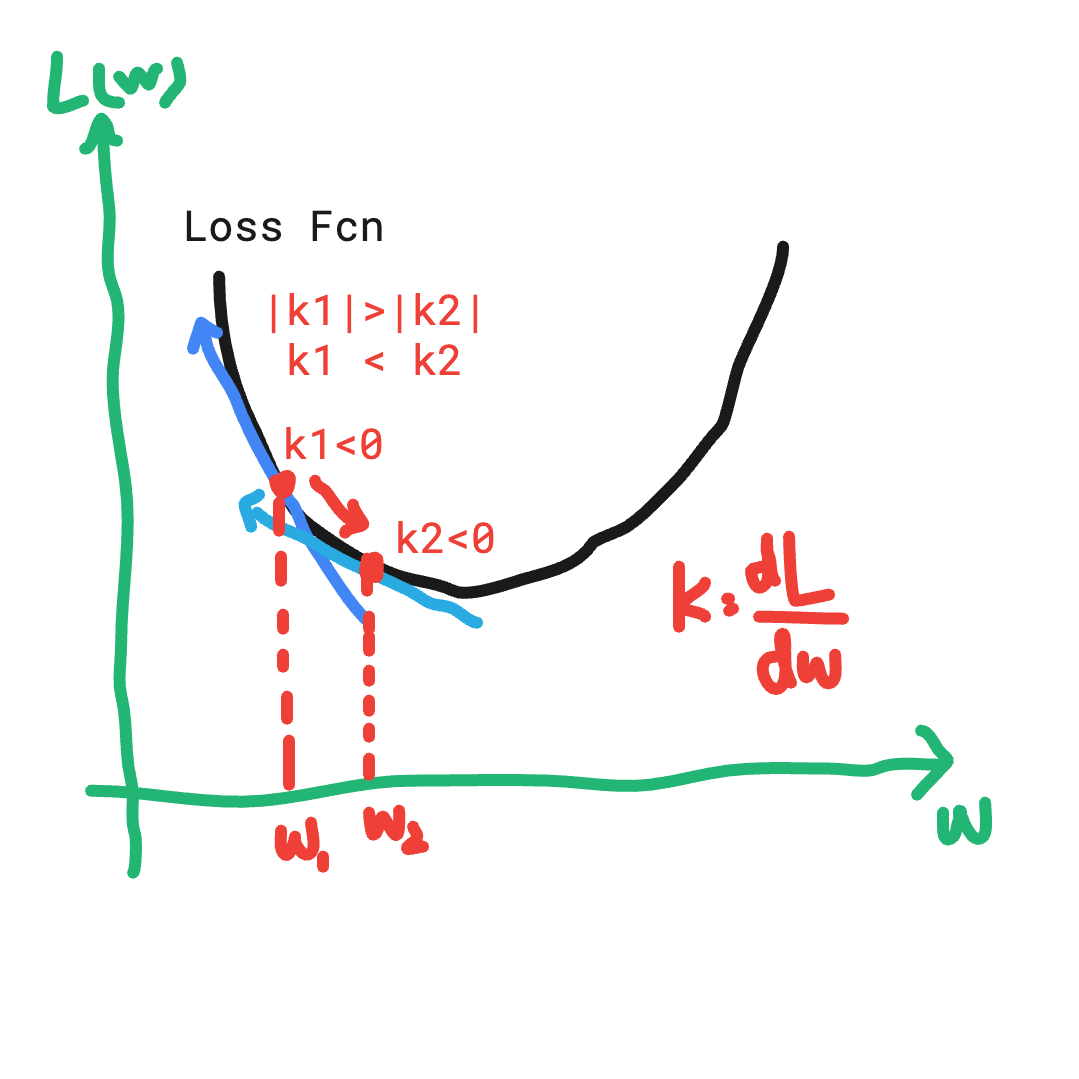

In [ ]:
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=500)[0].tolist()))


xiKi-RJ:CgqVuUa!U?qMH.uk!sCuMXvv!CJFfx;LgRyJknOEti.?I&-gPlLyulId?XlaInQ'q,lT$
3Q&sGlvHQ?mqSq-eON
x?SP fUAfCAuCX:bOlgiRQWN:Mphaw
tRLKuYXEaAXxrcq-gCUzeh3w!AcyaylgYWjmJM?Uzw:inaY,:C&OECW:vmGGJAn3onAuMgia!ms$Vb q-gCOcPcUhOnxJGUGSPJWT:.?ujmJFoiNL&A'DxY,prZ?qdT;hoo'dHooXXlxf'WkHK&u3Q?rqUi.kz;?Yx?C&u3Qbfzxlyh'Vl:zyxjKXgC?
lv'QKFiBeviNxO'm!Upm$srm&TqViqiBD3HBP!juEOpmZJyF$Fwfy!PlvWPFC
&WDdP!Ko,px
x
tREOE;AJ.BeXkylOVD3KHp$e?nD,.SFbWWI'ubcL!q-tU;aXmJ&uGXHxJXI&Z!gHRpajj;l.
pTErIBjx;JKIgoCnLGXrJSP!AU-AcbczR?


## Python: Put All Above Into `bigram.py` [00:38:00] With 2 Updates
1. Additional code to run on GPU device
2. Introduce `estimate_loss()` to average out noisy loss resulted from randomly sampled batches (some batch lucky, some not). [00:39:40]

[code is here](https://github.com/szhou12/gpt-from-scratch/blob/main/bigram.py)

## Math Trick in Self-Attention [00:42:14]
- An efficient implementation of self-attention.
- Previously, tokens (T) are NOT communicating with each other. Here, we want them communicate.
- However, one token should only talk to previous tokens, not to future tokens. e.g., 5th token should ONLY talk to 1st, ..., 4th tokens but not to 6th, ..., 8th tokens. This is because we want to predict the future.
- How to communicate?
    - For a time `i=t`, **average** the values (logits) along each channel `c` from `i=0,...,t` (including `t` itself)
    - The average value serves as a feature vecor that summarizes 'me' in the context of my history.
    - Note! sum/average is a lossy communication. We will lose info of spatial arrangements of these tokens. But it will work for now! We'll bring back spatial info back later.

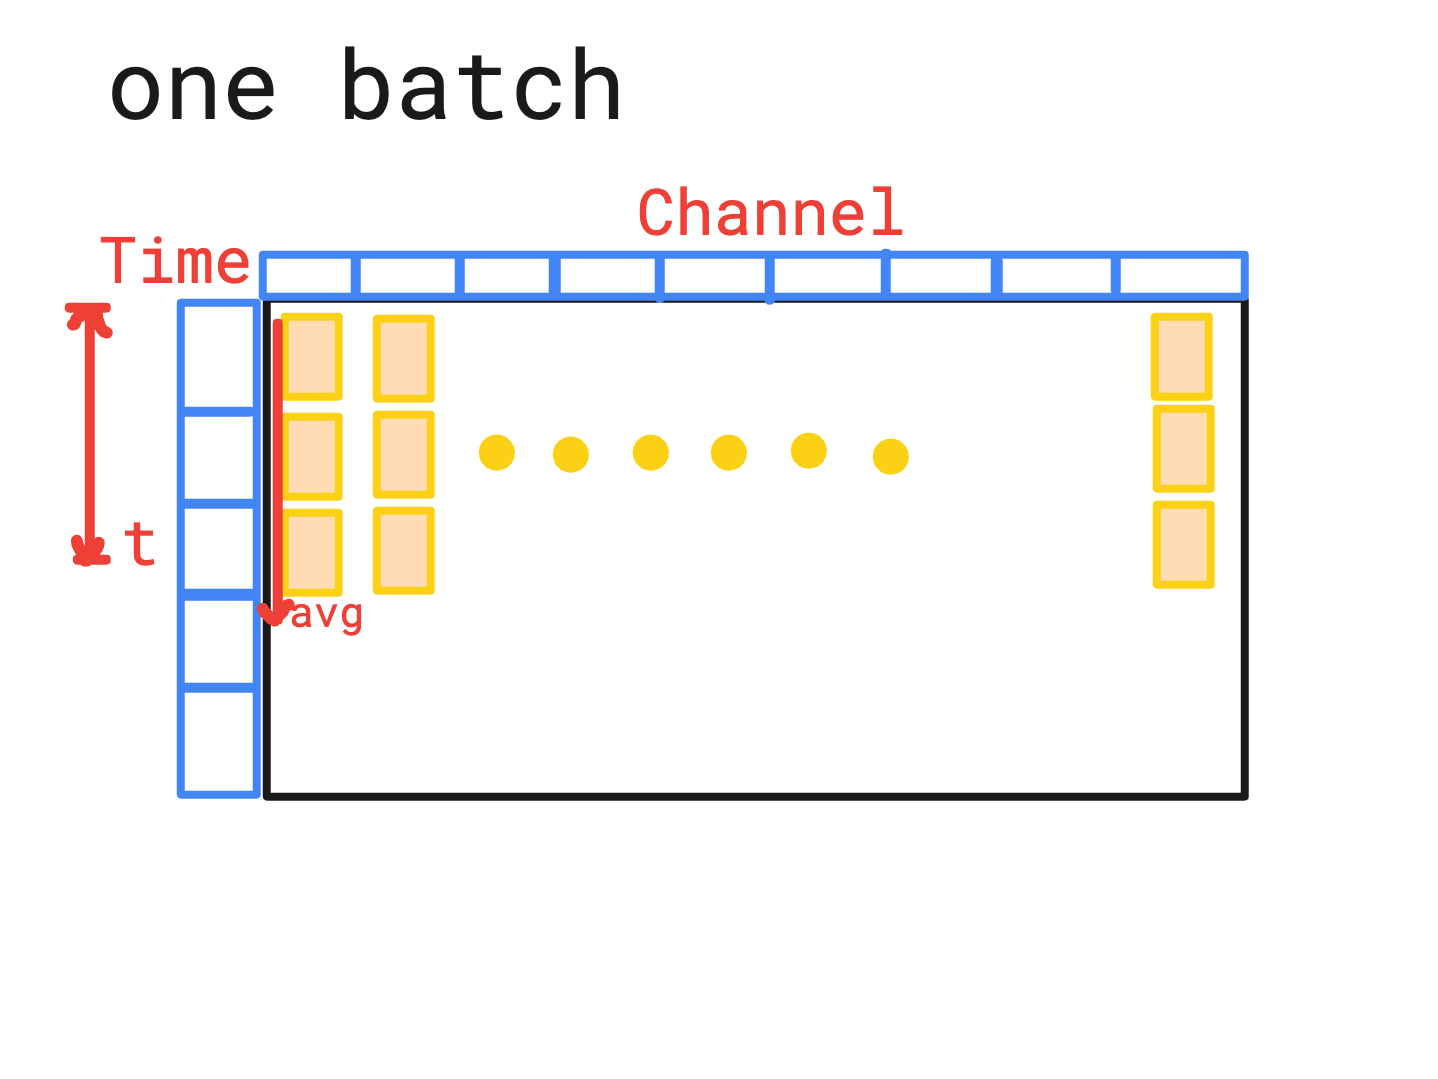

In [ ]:
# Consider the following toy example
torch.manual_seed(1337)
B, T, C = 4, 8, 2 # batch, time, channels
x = torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 2])

### Averaging Version 1 - Iterative

In [ ]:
# We want x[b,t] = mean_{i<=t} x[b,i]
# Let's do the averaging in iterative way (inefficient!)
xbow = torch.zeros((B,T,C)) # bow = bag of words - term that people use to average up things
for b in range(B): # given a batch
    for t in range(T):
        xprev = x[b,:t+1] # (t, C)
        xbow[b,t] = torch.mean(xprev, 0) # average out along t - squash i=0,...,t for each c

In [ ]:
x[0]

tensor([[ 0.1808, -0.0700],
        [-0.3596, -0.9152],
        [ 0.6258,  0.0255],
        [ 0.9545,  0.0643],
        [ 0.3612,  1.1679],
        [-1.3499, -0.5102],
        [ 0.2360, -0.2398],
        [-0.9211,  1.5433]])

In [ ]:
# -0.0894 = (0.1808 + -0.3596)/2
# 0.1490 = (0.1808 + -0.3596 + 0.6258)/3
xbow[0]

tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]])

**Here Comes The Trick! Step 1**
- Here, each cell of C is the sum of corresponding column of B:
- $C_{t1} = \sum_{i=1}^3 B_{i1}$ where $t=1,\cdots,3$
- $C_{t2} = \sum_{i=1}^3 B_{i2}$ where $t=1,\cdots,3$

In [ ]:
torch.manual_seed(42)
a = torch.ones(3,3) # matrix (3X3)
b = torch.randint(0,10,(3,2)).float() # matrix (3X2), each with random val (0~9)
c = a @ b # matrix (3X2)
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

a=
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[14., 16.],
        [14., 16.],
        [14., 16.]])


**magic function**: `torch.tril(X)`
- returns the lower triangular portion of the input matrix `X`. Upper triangular portion becomes 0.

In [ ]:
# magic function: torch.tril()
torch.tril(torch.ones(4,4))

tensor([[1., 0., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 1.]])

**Here Comes The Trick! Step 2**
- Here, each cell of C becomes the accumulated sum of corresponding column of B:
- $C_{t1} = \sum_{i=1}^t B_{i1}$ where $t=1,\cdots,3$
- $C_{t2} = \sum_{i=1}^t B_{i2}$ where $t=1,\cdots,3$

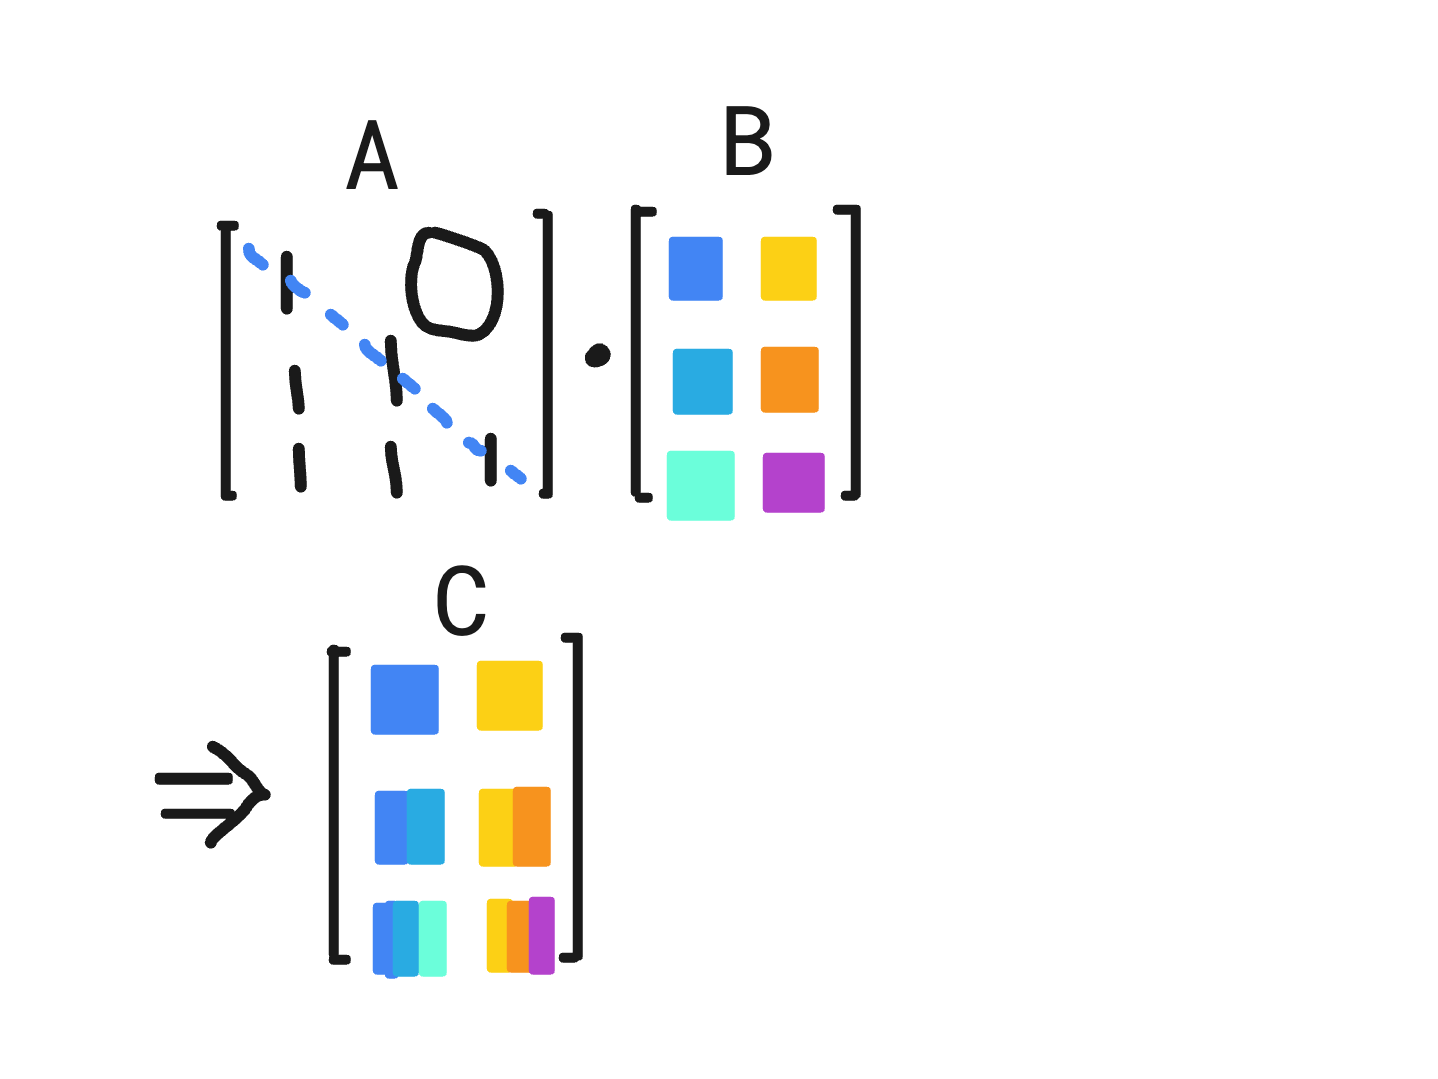

In [ ]:
torch.manual_seed(42)
a = torch.tril(torch.ones(3,3)) # Use tril() for a -> lower triangular matrix (3X3)
b = torch.randint(0,10,(3,2)).float() # matrix (3X2), each with random val (0~9)
c = a @ b # matrix (3X2)
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

a=
tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[ 2.,  7.],
        [ 8., 11.],
        [14., 16.]])


**Here Comes The Trick! Step 3**
- Here, each cell of C becomes the **average** of accumulated sum of corresponding column of B:
- $C_{t1} = \frac{1}{t} \sum_{i=1}^t B_{i1}$ where $t=1,\cdots,3$
- $C_{t2} = \frac{1}{t} \sum_{i=1}^t B_{i2}$ where $t=1,\cdots,3$

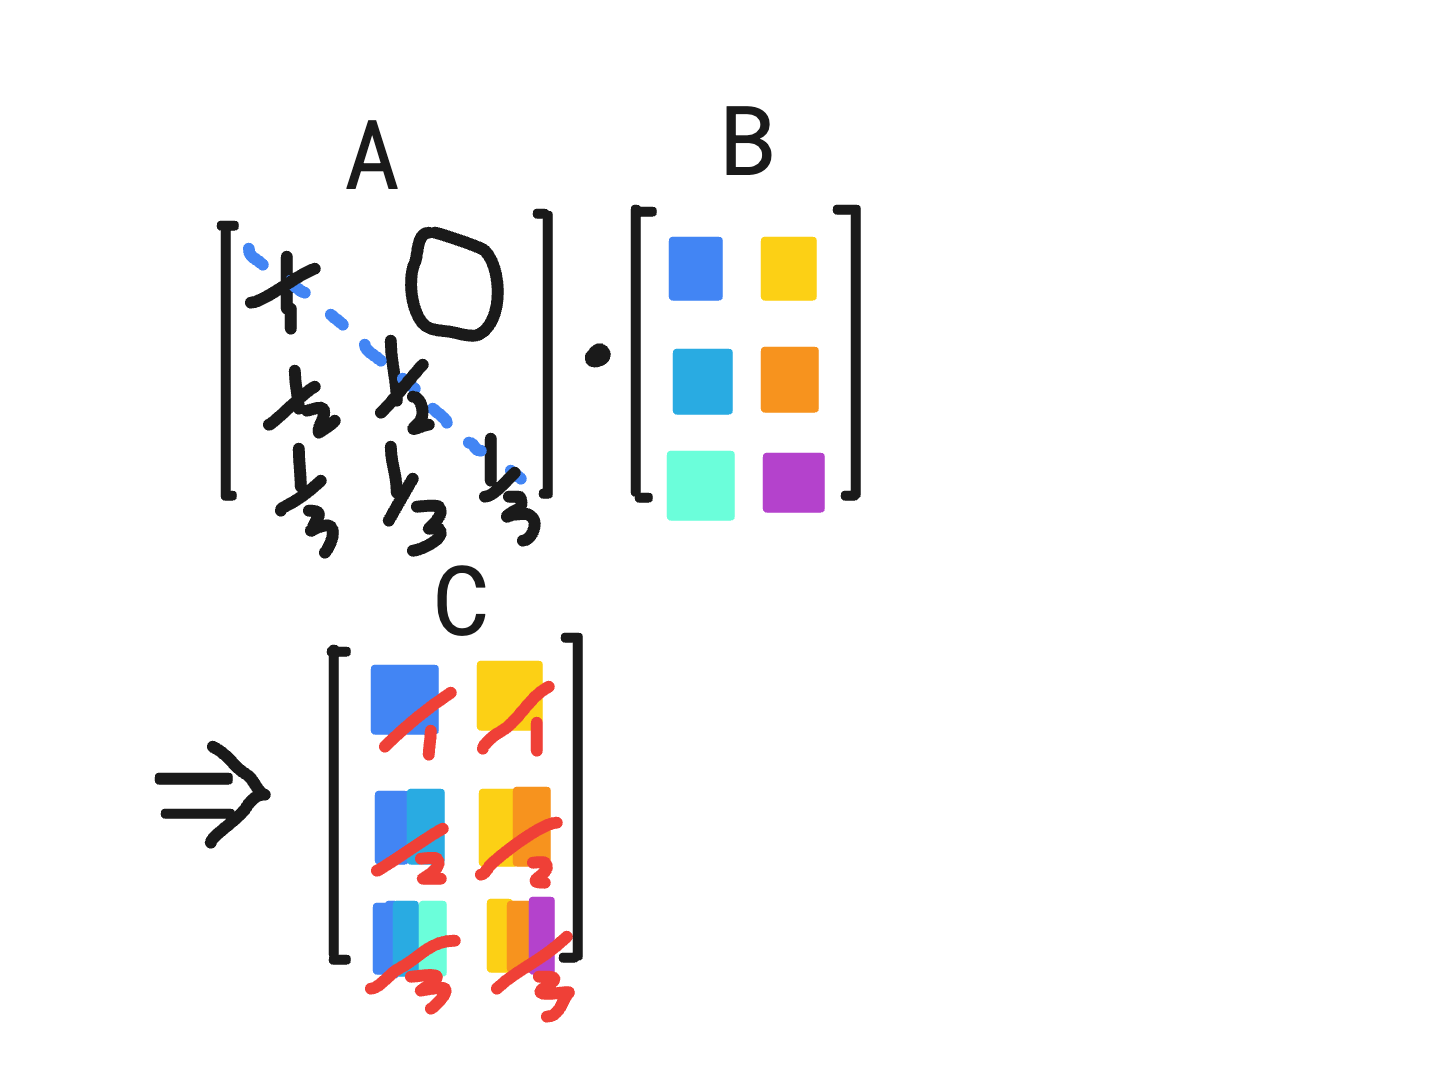

In [ ]:
torch.manual_seed(42)
a = torch.tril(torch.ones(3,3)) # Use tril() for a -> lower triangular matrix (3X3)
a = a / torch.sum(a, 1, keepdim=True) # sum(a, 1, keepdim=True) = sum each row of a (1 means along row direction) -> A=avg matrix. a1 = [1, 1/2, 1/3]
b = torch.randint(0,10,(3,2)).float() # matrix (3X2), each with random val (0~9)
c = a @ b # matrix (3X2)
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


### Averaging Version 2 - Matrix Multiplication
- **Now Time To Put All 3 Steps Together!**
- Keys to remember:
    1. `torch.tril(X)`
    2. `X / X.sum(1, keepdim=True)`


In [ ]:
# Consider the following toy example
torch.manual_seed(1337)
B, T, C = 4, 8, 2 # batch, time, channels
x = torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 2])

In [ ]:
# wei = A, x = B
wei = torch.tril(torch.ones(T, T))
wei = wei / wei.sum(1, keepdim=True)
# Pytorch detects the dim of wei and x don't match up, it will firstly pad with batch dimension (B) for wei. B number of copies of wei.
# Then apply matrix multi
xbow2 = wei @ x # (T, T) @ (B, T, C) --> (B, T, T) @ (B, T, C) --> (B, T, C)
torch.allclose(xbow, xbow2, atol=1e-07)

True

In [ ]:
xbow2[1]

tensor([[ 1.3488, -0.1396],
        [ 0.8173,  0.4127],
        [-0.1342,  0.4395],
        [ 0.2711,  0.4774],
        [ 0.2421,  0.0694],
        [ 0.0084,  0.0020],
        [ 0.0712, -0.1128],
        [ 0.2527,  0.2149]])

In [ ]:
xbow[1]

tensor([[ 1.3488, -0.1396],
        [ 0.8173,  0.4127],
        [-0.1342,  0.4395],
        [ 0.2711,  0.4774],
        [ 0.2421,  0.0694],
        [ 0.0084,  0.0020],
        [ 0.0712, -0.1128],
        [ 0.2527,  0.2149]])

### Averaging Version 3 - Matrix Multiplication Using Softmax
```
tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T, T))
wei = wei.masked_fill(tril==0, float('-inf'))
wei = F.softmax(wei, dim=-1)
```
are doing the same thing as
```
wei = torch.tril(torch.ones(T, T))
wei = wei / wei.sum(1, keepdim=True)
```

Q: This version using softmax will be applied to self-attention. Why?
1. Weights `wei = torch.zeros((T, T))` begin as 0. Think of them as the interaction strength or affinity. It's telling us how much of each token in the past we want to aggregate and average up. During the training, the values (affinities between tokens) won't remain 0 but rather data dependent, meaning that tokens will start looking at each other and finding other tokens more or less interesting. The values (so-called affinities) represent the interesting level (感兴趣程度) one token on another token.
2. Then, `wei = wei.masked_fill(tril==0, float('-inf'))` is saying that tokens from the past cannot communicate with the future. (很自然的, 在当下写下一个词的时候, 只能根据前文写下的词作判断, 无法知道未来会写的词) By setting them negative infinity, it's saying that we will not aggregate anything from those tokens. 注意：`wei`是 T X T, 也就是说两个维度都代表时间, 从past到future.
3. `wei = F.softmax(wei, dim=-1)` is normalization
4. `xbow3 = wei @ x` is the aggregation of values depending on how interesting tokens find with each other.


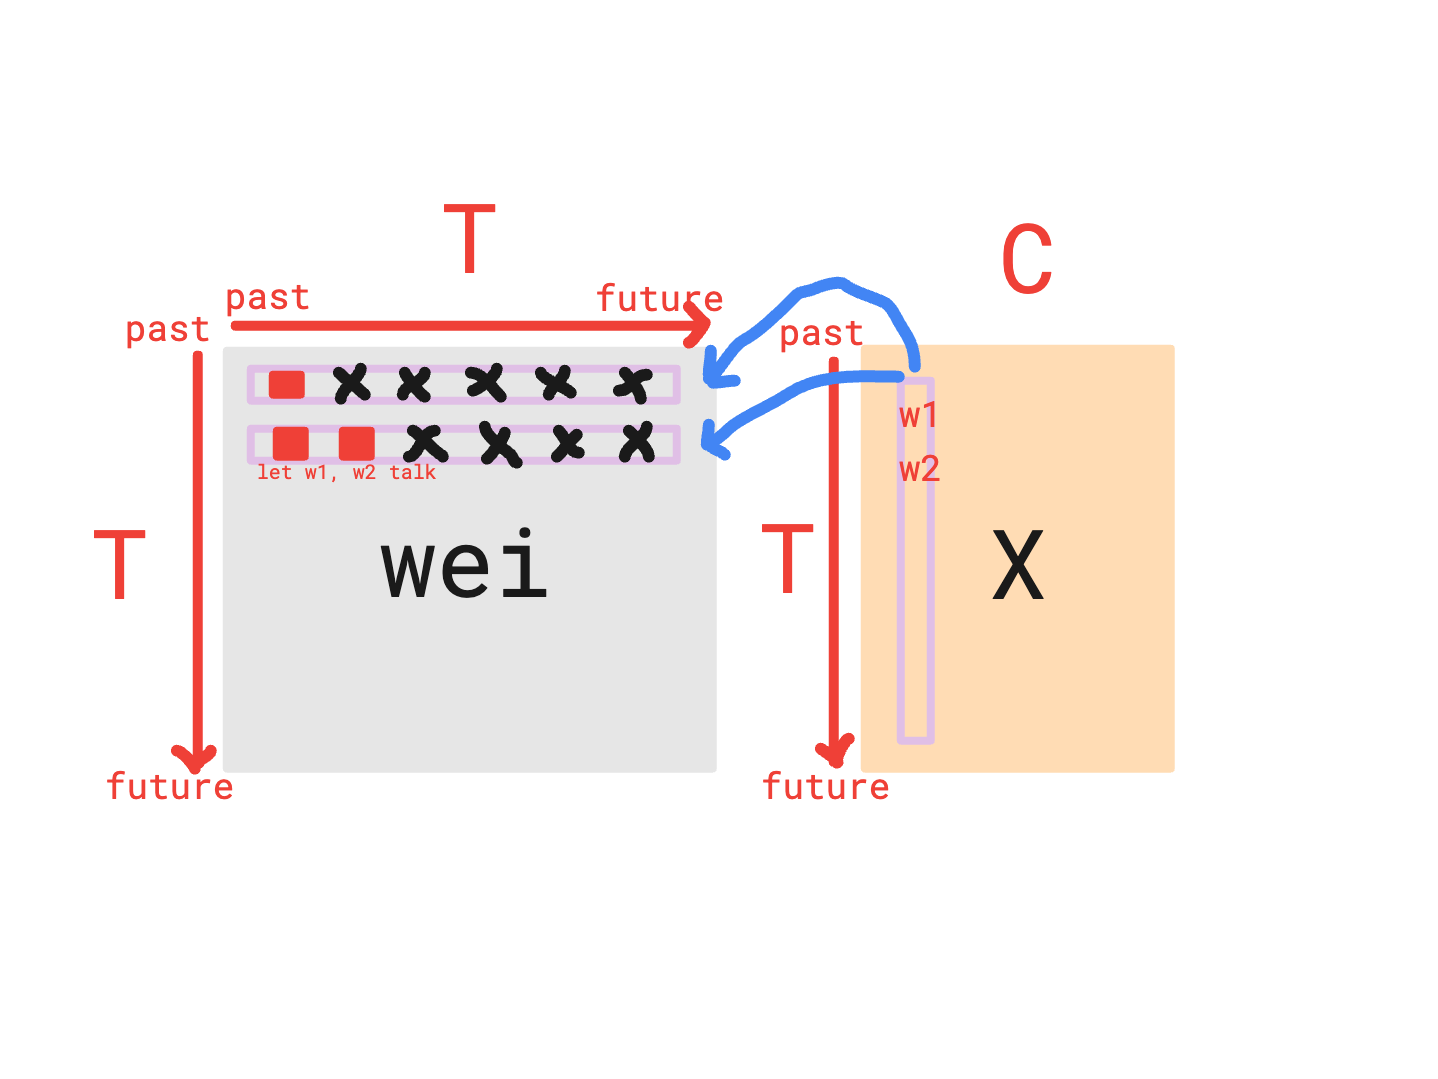

In [ ]:
# wei = A, x = B
tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T, T))
# For every position in wei, if its corresponding cell in tril==0, replace this cell in wei with -inf.
wei = wei.masked_fill(tril==0, float('-inf')) # fill every tril cell == 0 with -inf. wei now only has 2 values: 0 and -inf
wei = F.softmax(wei, dim=-1) # apply softmax along the last dim which in the case of wei is dim=1 aka along each row
xbow3 = wei @ x
torch.allclose(xbow, xbow3, atol=1e-07) # check if xbow3 get the correct values

True

## Python: Improve Using The Trick: bigram_v2.py [00:58:28]
1. Take out `vocab_size` as input arg of `BigramLanguageModel`, making it global variable.
2. Inroduce a new global variable `n_embd =` embedding dimension.
3. In `forward()`, replace `logits` with `tok_emb` in embedding layer.
4. Add a linear layer in the constructor.
5. Add a position embedding layer below token embedding layer and above linear layer. Position embedding layer encodes position info of tokens.

## Crux of Self-Attention [1:02:00]


### Pytorch Recap
- `nn.Linear(input_size, output_size, bias)`: 线性变换层 (linear transformation layer)
- 生成 $y=xW^T+b$ 中的 $W$ (weight) 和 $b$ (if `bias=True`)
- 实验:
```
m = nn.Linear(20, 128) // bias default True
print(m.weight.size()) // torch.Size([128, 20])
```
- 通过实验, 我们发现, Pytorch会在内部进行维度变换, 即, output_size先于input_size
- 一开始接触时, Pytorch在内部进行的维度变换可能会有点迷惑: 如果`x=BxTxC`, 那么我们应该认为:
    1. `W=Cx16`还是`W=16xC`? `16xC` (`output x input`)
    2. `nn.Linear(C,16).weight`表示的是$W$还是$W^T$? $W$
- 但其实, 并不需要mentally想象Pytorch怎么实现的矩阵相乘: $xW^T$. 只需要明确 data `x`的输入维度(需要消掉的维度)是多少, `nn.Linear()`第一个arg保证与`x`相消的维度保持一致, 第二个arg表示想要的输出维度就可以了。
    - 硬要细究的话, `(input,output)=`$W^T$, `m=nn.Linear(input,output)=`$W$, 而`m(x) = x @ (input,output)`
- `bias=False`的含义: 如果不包含bias, 线性层就是简单的matrix multiplication with fixed some weights.

### Self-Attention Mechanism Explanation
1. Notice that `wei = torch.zeros((T, T))`, meaning that each token/row is initialized uniformly so that `wei @ x` is just the simple average of each row. However, we don't want `wei` to be uniform at all times because some tokens may find other tokens more or less interesting depending on the data `x`.
    - e.g. a vowel may find a consonant interesting. Thus, it wants to know what those consonants are and has these information flow to it.
2. Self-attention solves this problem: **"How to gather information from the past in a data dependent way?"**
3. Solution:
    1. Every single token/node at each position will emit two vectors: `query`, `key`.
        - `query`: "what am I looking for?"
        - `key`: "what do I contain?"
            - information in `key` (values represented in `key`) can mean: "I am a consonant", "I'm in X-th poisition", etc.
    2. The way to get raw affinities between these tokens = `query @ key`
        - (my query) `@` (other tokens' keys) = `wei`
        - if a key and a query are aligned, they will interact to a high amount, meaning that I (row i), as the current token, get to learn more from this specific token (col j) than anyone else.
        - when a cell `wei[k][i][j]` has high affinity, then through softmax, I (row `i`) will end up aggregating a lot of its (col `j`) information into my position, meaning that I get to learn a lot about it. (`k`= k-th batch)
        - The affinity is also called as **"attention score"**.
    3. Let `wei` go through **softmax** to have a distribution summing up to 1. This is telling us that in a data-dependent manner, how much of information to aggregate from any of these tokens in the past.
    4. We DON'T simply use `softmax(wei) @ x`. Instead, we create a `value` vector (same shape as `query` and `key`). `value`同`query` and `key`一样, 也是线性变换层。
        - Replace raw `x` with `v = value(x)`. Then, `softmax(wei) @ v`.
        - `x` = private information to this token. So `x` is private to this token. All information of one token is kept in vector `x`.
        - `value(x)` = encoded actual content of `x`. The thing that gets aggregated for the purpose of this single head between different tokens/nodes.
4. The Party Example - Explaining `query`, `key`, `value` to Non-expert:
    - Situation: Imagine you're at a crowded party ("data ocean"), trying to listen to a friend's story amidst numerous conversations happening around you. In this scenario:
    - Who am I? "You" = `single head`.
    - `query`: **Your Interest or Focus**. Represent your interest or focus at any given moment. When you're trying to follow your friend's story, your "query" is the specific part of the story or the context you're currently focusing on. It's like asking, "What parts of all these conversations are most relevant to the story I'm trying to follow?" 表示你目前的注意力是什么, 在哪里, 关注的是什么主题的“声音”？
    - `key`: **Topic of Each Conversation**. Represent the contextual cues or topics of all the conversations happening around you. Each conversation has a "key" that signifies what it's about. Your brain uses these keys to determine which conversations are relevant to the story you're interested in. 线索暗示你周围的所有这些“声音”是什么主题的。
    - `value`: **Actual Content of Each Conversation**. Represent the actual content of the conversations. Once your brain decides which conversations are relevant (based on the keys), the "values" are the details or the substance of those conversations that you actually listen to and process to understand the story. 每种主题的"声音"它具体的内容是什么。
    - `wei = query @ key`: Measuring the similarity or relevance between what you're interested in and each of the conversations happening around you. In practical terms, this is like your brain automatically evaluating which conversations are worth listening to more closely based on how closely they match what you're currently interested in or thinking about. 就好像每种主题的“声音”都在朝你喊: “我有关! 听我的故事!” 但每种“声音”的音量依据你的兴趣点而有大有小, 这个“分贝”由`query @ key`表示。显然, 越大的"分贝"越容易引起你的注意。
    - `softmax(wei)`: These scores represent the proportion of attention (or focus) that each conversation (input piece) gets. In the party context, this would be akin to deciding how much of your attention to allocate to each conversation based on its relevance to your interest.
    - `value(x) vs. x`: The necessity of using value vector instead of raw data? 在派对上, 你没有精力对每种“声音”的具体内容逐字逐句的了解(raw data `x`), 只能通过提取总结出的关键信息(`value(x)`)高效地还原完整的故事。
        1. Essence: Values encapsulate the essence or the most useful features of the input data for the task at hand. They represent a high-level, contextualized understanding of the input, tailored through learning to the task the model is performing.
        2. Efficiency: Values allow the model to process and integrate the most relevant and useful information from the input data efficiently.

In [ ]:
# version 4: self-attention!
torch.manual_seed(1337)
B, T, C = 4, 8, 32 # batch, time, channels
x = torch.randn(B,T,C)

# let's see a single Head perform self-attention
head_size = 16 # head_size is a hyperparam
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)

"""
让x穿过矩阵线性变换key/query意味着:
 1. All tokens in (B x T) arrangement in parallel and independently produce a key vector (size=16) and a query vector (size=16)
 2. NO communication happened yet!
 3. 简单理解: 线性转换就是把x中的Channel维度大小变成head_size大小, 就是简单地改变了C维度, 把每个token在C维度上的信息独立地压缩成head_size大小
"""
k = key(x)   # (B, T, 16) B个句子,每个句子T个词,每个词表示成长度=16的向量
q = query(x) # (B, T, 16) B个句子,每个句子T个词,每个词表示成长度=16的向量

"""
Communication happens here!
Extract affinities between tokens by dot product key and query
1. key的信息(size=16)对着query的信息(size=16), 合在一起(点积)变成表示两个token之间affinitiy的值 (感觉有点像correlation), 把它用作weights
2. 注意! communicaton only happens within a batch! batch与batch之间是没有交流的, 所以 weights between batches are data-independent
"""
# k.transpose(-2, -1) = transpose k's last two dims
wei = q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) => (B, T, T)
"""
举个例子:
wei[0][i][j] := In batch 0, how interested of token i is in token j a.k.a raw affinities/interactions between all token pairs.
By 'raw', we mean that wei has NOT gone through masked_fill & softmax yet.
e.g. wei[0][7][3] 如果是一个相对较大的值, 表示8号位子token(t=8)觉得4号位子(t=4)token很有趣, 他俩组cp的可能性很高
注意! 某一token只能看到截止到它当前时间线的tokens(i.e. i>=j). 当i<j, wei=0.00000
"""

tril = torch.tril(torch.ones(T, T))
# wei = torch.zeros((T, T)) # we use key @ query to replace it so that instead of uniform weights, we have data-dependent weights
wei = wei.masked_fill(tril==0, float('-inf')) # mask out with -inf so that upper triangular portion is not observable
wei = F.softmax(wei, dim=-1) # normalization to have distribution sums up to 1.
# out = wei @ x
v = value(x) # (B, T, 16)
out = wei @ v # (B, T, T) @ (B, T, 16) => (B, T, 16)

out.shape

torch.Size([4, 8, 16])

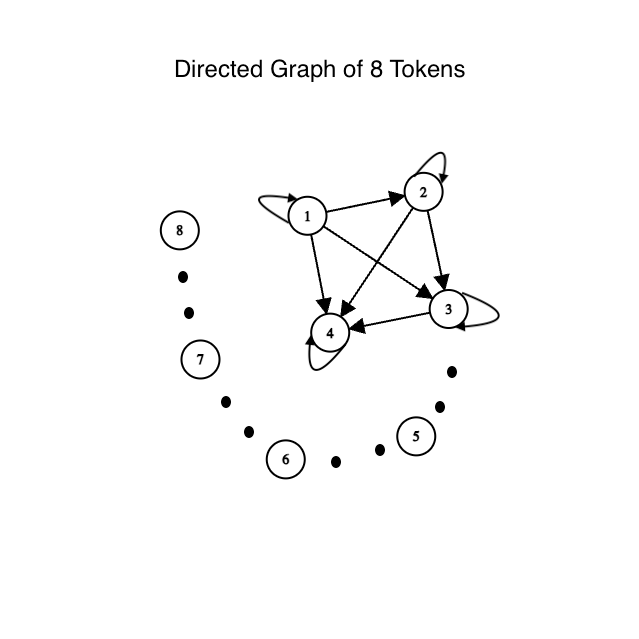

## Notes: [1:11:40]
1. Attention is a **communication mechanism**. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.
    - See "directed graph of 8 tokens" above (directed edges to node 5 and beyond are ignored for better presentation): For any node `i` (i.e. token `i`), there will be a directed edge pointing to `i` from all nodes `j` where `j = 1, ..., i`.
    - e.g. `1->1`; `1->2`, `2->2`; `1->3`, `2->3`, `3->3`; ...
2. There is **no notion of space**. Attention simply acts over a set of vectors. This is why we need to positionally encode tokens.
    - By default, these nodes have no idea where they are positioned in the space. Thus, we need to encode them positionally, giving them some information that is anchored to their specific positions so that they know where they are.
    - 不像convolutional layer, 它的filter (e.g. 3x3)在移动提取特征时天然地encode local spatial information.
3. Each example across batch dimension is of course processed completely independently and never "talk" to each other.
4. In an **"encoder"** attention block just delete the single line that does masking with `tril`, allowing all tokens to communicate. This block here is called a **"decoder"** attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling.
    - Encoder: No `wei = wei.masked_fill(tril==0, float('-inf'))`
    - Decoder: Has `wei = wei.masked_fill(tril==0, float('-inf'))`
5. **"self-attention"** just means that the queries, keys, values all are produced from the same source `x`. In **"cross-attention"**, the queries still get produced from `x`, but the keys and values come from some other, external source (e.g. an encoder module).
6. "Scaled" attention additionally divides `wei` by $\frac{1}{\sqrt{headsize}}$. This makes it so when input Q,K are unit variance, `wei` will be unit variance too and `softmax()` will stay diffuse and not saturate too much. Illustration below:


## Scaled Attention [1:16:59]
$$Attention(Q,K,V) = softmax(\frac{QK^T}{\sqrt{d_k}})V$$
- $d_k=$ `head_size`

### Pytorch Recap
- `torch.randn(B, T, head_size)`: returns a tensor of dimension B x T x headsize filled with random numbers sampled from  the standard normal distribution $N(0,1)$.

### Why Var(`wei`) = `head_size`?
- `wei = q @ k.transpose(-2,-1)` before scaling.
- First, look at only the last dimension (`head_size` dimension) of `q` and `k`. Each vector has the size = `head_size`
- Suppose `head_size` $=n$
- Let one vector of $Q$ be $q = [a_1, \cdots, a_n]\in$ `q` where each $a_i$ is **independently** drawn from $N(0,1)$.
- Let one vector of $K$ be $k = [b_1, \cdots, b_n]\in$ `k` where each $b_i$ is **independently** drawn from $N(0,1)$.
- Then, $q\cdot k = \sum_{i=1}^n a_ib_i$
- We know that: Given $X, Y$ are two independent variables, $X\sim N(0,1)$, $Y\sim N(0,1)$,
 1. $Var(X)=E(X^2)-[E(X)]^2 \Rightarrow E(X^2)=Var(X)+[E(X)]^2=1+0=1$
 2. $Var(XY)=E(X^2)E(Y^2)-[E(X)]^2[E(Y)]^2 = 1\cdot 1 - 0\cdot 0  = 1$
- $a_ib_i$ and $a_jb_j$ are independent because each $a_i$, $b_i$ are independent. (i.e., Knowing the value of $a_ib_i$ gives no information about the value of $a_jb_j$, and vice versa)
- Thus, $Var(qk) = Var(\sum_{i=1}^n a_ib_i) = \sum_{i=1}^n Var(a_ib_i) = \sum_{i=1}^n 1 = n$
- This means that each element/cell in `wei` has the variance of `head_size`. Then, all elements/cells together (B x T x headsize) have variance of `head_size`. This means that B and T only determine the shape of `wei` while the variance of each cell is determined solely by headsize.

### Why divides $\sqrt{headsize}$ instead of headsize?
- Recall the scaling property of variance: $Var(aX) = a^2Var(X)$
- Thus, $Var(\frac{1}{\sqrt{headsize}}QK^T) = \frac{1}{headsize}Var(QK^T)$

### Why is it important to scale by $\frac{1}{\sqrt{headsize}}$?
- **TL;DR**: 避免Softmax走极端导致信息的聚集趋于单一化。
- `softmax()`有这么一个特性: 让小的更小, 让大的更大。
- `wei` will be fed into `softmax()`. So it's important that, especially at initialization, the weights are fairly diffused. If weights take on some very positive/negative numbers, softmax will converge towards one-hot vectors. In the example below, when the tensor is multiplied by 8, after the softmax, all first 4 cells end up with values close to 0 while the last one close to 1 ("sharpens the vector towards the max (cell)"). It becomes a one-hot vector `[0,0,0,0,1]`. The result of this means that you are basically aggregating information from just one single node. Thus, the scaling is used to control the variance at initialization.

In [ ]:
k = torch.randn(B, T, head_size)
q = torch.randn(B, T, head_size)
wei = q @ k.transpose(-2, -1)
wei_scaled = q @ k.transpose(-2, -1) * head_size**-0.5

In [ ]:
k.var()

tensor(1.0449)

In [ ]:
q.var()

tensor(1.0700)

In [ ]:
wei.var() # variance = head_size = 16

tensor(17.4690)

In [ ]:
wei_scaled.var() # variance = 1

tensor(1.0918)

In [ ]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1)

tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])

In [ ]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5])*8, dim=-1) # gets too peaky, converges to one-hot

tensor([0.0326, 0.0030, 0.1615, 0.0030, 0.8000])

## Python: Add Self-Attention to make bigram_v3.py [1:19:14]
- 01:19:14 inserting a single self-attention block to our network
- 01:21:59 multi-headed self-attention
- 01:24:25 feedforward layers of transformer block
- 01:26:48 residual connections
- 01:32:51 layernorm (and its relationship to our previous batchnorm)
- 01:37:49 scaling up the model! creating a few variables. adding dropout
1. Single-Head Self-Attention --> loss $↓$
    1. `Head` class: a `torch.nn.Module` type of class
    2. `BigramLanguageModel(nn.Module)`: add single self-attention head
        1. add self-attention head in `__init__`
        2. add self-attention head in `forward()` after (tokenization + positional encoding)
        3. crop input `idx` in `generate()` so that the size of `idx` fed into the model won't exceed the block size. This is to prevent the positional embedding from running out of scope.
2. Adjust Hyperparameters
    1. Decrease the learning rate because self-attention can't tolerate high learning rate.
        - *Can you explain why?*
    2. Increase max number of iterations as the learning rate is lower.
3. Switch to Multi-Headed Self-Attention --> loss $↓$
    1. `MultiHeadAttention(nn.Module)` class:
        - Multi-Headed Attention In 1 Sentence: It's applying multiple attentions (`Head`) in parallel and in concatenating the results.
    2. `BigramLanguageModel(nn.Module)`: switch to multi-head
        1. `self.sa_heads`: group and encapsulate many `Head` within `MultiHeadAttention`.
        - Notice: `Head(head_size=32)` == `MultiHead(num_heads=4, head_size=32/4=8)`.
        - *Can you explain why doing so?*
4. Add Position-Wise Feed-Forward --> loss $↓$
    1. `FeedFoward(nn.Module)` class: [1:24:27]
        - It's a simple MLP: fully-connected layer.
        - Purpose: adding computation into the network. This computation is on the per-node/per-token level, meaning that every token does this computation independently (aka 'Position/Element-wise' non-linearity). Think this way: self-attention mechanism is to let tokens communicate with each other. This following feed-foward layer is to let each token take a minute to "think" about the communication individually.
        - Implementation: single layer --> linear layer + ReLU non-linearity
        - Inject this class into `BigramLanguageModel` right after `self.sa_heads`
        - *Can you explain why adding feed-forward?*
    2. `BigramLanguageModel(nn.Module)`: add position-wise feed-forward
        1. add `self.ffwd()` after `self.sa_heads`
5. Block: encapsulate (multi-headed self-attention + position-wise feed-forward) and replicate $N$ times
    1. `Block(nn.Module)` class: [1:26:35]
        - Represent the entire decoder block that intersperses the communication with the computation.
    2. `BigramLanguageModel(nn.Module)`: use `self.blocks`
        1. move `self.sa_heads`, `self.ffwd()` into `Block()` class.
        2. replace them with `self.blocks()`
        3. **NOTE!** The loss will not decrease because at this stage, we are having a very deep neural network. A deep neural network by nature suffers from the optimization issue.
6. Residual Connection --> loss $↓$ overfitting shows up (train loss < valid loss)
    1. In `Block` class, `forward()` method:
        1. `x = self.self_sa(x)` --> `x = x + self.self_sa(x)`
        2. `x = self.ffwd(x)` --> `x = x + self.ffwd(x)`
    2. In `MultiHeadAttention` class: add projection that projects result back to the residual pathway
        1. `__init__()`: introduce `self.proj`
        2. `forward()`: apply `self.proj` on concatenated result.
    3. In `FeedFoward` class: add projection too
        1. `__init__()`: add another `nn.Linear` after ReLU.
        2. linear layer "领域展开": `nn.Linear(n_embed, 4*n_embed)` before ReLU; `nn.Linear(4*n_embed, n_embed)` after ReLU.
7. Layer Normalization --> loss $↓$
    1. In `Block` class, `__init__()`:
        1. add `self.ln1 = nn.LayerNorm(n_embed)`
        2. add `self.ln2 = nn.LayerNorm(n_embed)`
    2. In `Block` class, `forward()` method:
        1. `x = x + self.self_sa(x)` --> `x = x + self.self_sa(self.ln1(x))`
        2. `x = x + self.ffwd(x)` --> `x = x + self.ffwd(self.ln2(x))`
    3. In `BigramLanguageModel(nn.Module)`, `self.blocks`:
        1. add `nn.LayerNorm(n_embed)` at the end of sequence of blocks right before the last linear layer that decodes into vocabulary.
8. Scale Up Model & Dropout [1:37:45]
    1. In `BigramLanguageModel(nn.Module)` class, `__init__()`:
        1. change to `self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])` where `n_layer=4` is a hyperparameter.
        2. add LayerNorm `self.ln_f = nn.LayerNorm(n_embed)`
    2. In `BigramLanguageModel(nn.Module)` class, `forward()`:
        1. apply LayerNorm after `self.blocks`: `x = self.ln_f(x)`
    3. Add Droupout:
        1. hyperparameter `dropout = 0.2`: In one forward-backward pass, 20% of intermediate calculations are disabled and dropped to 0.
        2. In `MultiHeadAttention` class,
            - `__init__()`: declare `self.dropout = nn.Dropout(dropout)`
            - `forward()`: apply `out = self.dropout(self.proj(out))`
        3. In `FeedFoward` class,
            - `__init__()`: append `nn.Dropout(dropout)` to `self.net`
        4. In `Head` class,
            - `__init__()`: declare `self.dropout = nn.Dropout(dropout)`
            - `forward()`: apply `wei = self.dropout(wei)` after `wei = F.softmax(...)` and before `x = self.value(x)`
9. Summarize hyperparameters at the top  --> loss $↓$
    - increase `batch_size=64`
    - increase `block_size=256`: previously it's 8-character of context predicting the next, now it's 256-chararacter of context predicting 257th.
    - lower `learning_rate`: because our neural network is now deeper
    - adjust `n_embd=384`
    - adjust `n_head=6`
    - set `n_layer=6`: 6 layers of whole decoder blocks
    - set `dropout=0.2`

### Why intolerance of high learning rate is prominent in self-attention mechanism?
1. First of all, deep neural network (DNN) in general is NOT tolerant of high learning rates for 2 dominant reasons:
    1. Easily Sensitive: When DNN becomes deeper (more layers), DNN becomes moe sensitive to high learning rates. This sensitivity arises because high learning rates can lead to weight updates that are too large. 小小一步就可能导致weight过度更新。
    2. Vanishing & Exploding Gradients: DNN is prone to vanishing or exploding gradients, phenomena where gradients become too small or too large to propagate useful learning signals through all layers effectively. High learning rates can exacerbate these issues, making it difficult for the network to learn. DNN天然地容易造成梯度消失/爆炸(主因:连乘机制), 高学习率会更加恶化这个特质。
2. Plus, self-attention mechanism is particularly NOT tolerant of high learning rates because **a mechanism that involves complex, dense interactions between all parts of the input data can make the model's output highly sensitive to changes in its parameters**. To explain the logic of this sentence:
    1. Complex, Dense Interactions: In the context of transformers and self-attention, every part of the input data (e.g., every word in a sentence) interacts with every other part. This is unlike traditional architectures where inputs interact in more constrained patterns (e.g., nearby regions in convolutional neural networks). The self-attention mechanism computes attention scores that represent the relevance or importance of all parts of the input relative to each other for a given task. 因为self-attention是一次性看到全局的data, 所以任何地方weight的微小变动都牵连到全局的data。
    2. High Sensitivity to Parameters: The weights (parameters) in the self-attention mechanism directly influence how these attention scores are computed. A small change in the weights can significantly alter the computed attention scores, leading to a different set of interactions being emphasized. Since the final output of the model is a result of aggregating these interactions based on the attention scores, even minor changes in parameters can lead to markedly different outputs. 这个模型的机制又是产出整合(aggregate)的全局信息 (sum average), 所以任何地方的微小变动都会被整合进输出的信息中, 所以影响又“滚雪球”般地进一步放大了。
    3. Gradient Descent and Learning Rate: During training, models adjust their parameters (weights) based on the gradients of a loss function, which measures the difference between the model's predictions and the actual target values. The learning rate determines the size of the step taken in parameter space in response to these gradients. If the learning rate is too high, the steps might be too large, causing the model to overshoot optimal solutions or to oscillate unstably. Given the high sensitivity of outputs to parameter changes in mechanisms like self-attention, these issues are exacerbated, making it crucial to use an appropriately calibrated learning rate. 学习率本身就是调整weight变大变小的幅度, 如果一次幅度过高, “微小”变动就会加重并累积进下一次迭代中。

### Why use 4 multi-heads, each with head size=8 instead of a single head with head size=32?
- Formal explanation: Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. With a single attention head, averaging inhibits this.
- 通俗理解: 多个两只手的盲人摸象 > 一个多只手的盲人摸象
    - 多人的情况下, 就可以每人只负责一小部分, 尽可能多的搜集负责部分的信息。这样合在一起的时候, 还原的全貌就可以提供更多信息。
- Three Advantages:
    1. Diverse Representation Learning:
        - One head focuses on only one aspect of data. All together offer various aspects of data.
        - This diversity allows tolearn a richer representation of the data.
        - 每个头专攻一个位面, 互不侵扰。叠加在一起的时候, 就提供了对data的多维度理解。这个多样化本身提供了更多的信息。
    2. Increased Model Flexibility
        - Multi-head attends to multiple aspects of the input simultaneously. Useful for complex task that naturally involves understanding multiple aspects all at once.
        - Learning diversity gives robustness to variations and better generalizability.
        - 有些复杂的任务天然地需要分解成不同位面各自学习再整合(类比受力分析的正交分解)。多样化让模型本身更强健并具有较好的泛化能力。
    3. Efficiency and Performance
        - Multiple smaller heads can lead to a more effective use of model parameters.
        - The computations of the different heads can be performed in parallel.
        - 尺寸小的头参数利用率高。多个头可以利用并行运算提高计算效率。


### What does "Adding Computation" mean in Feed-Forward?
- **TL;DR**: **Introduce Non-Linearity Element-Wise + Add more learnable parameters** to better fit data.
- Through self-attention, tokens talk and collect information from each other. However, they don't have enough time to "think" on the gathered data individually. By "thinking individually", we mean to firstly transform features through linear layer, and then apply ReLU to introduce non-linearity to each cell of the matrix individually.
- self-attention层做的事是tokens之间的dependencies, 虽然也有softmax来引入non-linearity, 但是是应用在所有看到的tokens的值整合起来再加上non-linearity, 一种群体buff的感觉。feed-forward层做的则是用ReLU对matrix的每一个cell的值单独地引入non-linearity, 一种单体buff的感觉。同时, ReLU之前的线性转换引入了更多可以学习的参数。

### Why a very deep neural net suffers from optimization issue?
- Vanishing & Exploding Gradients
    - 因为梯度连乘的关系, 梯度是以指数级减小/增大, 会在很快的时间使weight变成0或者无穷大。
    - 想象传话的游戏, 当队伍越长, 原本的话就越容易在传递过程中产生信息丢失(vanished)或者信息扭曲(exploded)

### What are 2 optimization solutions for a very deep neural net?
1. Residual Connection
    - **TL;DR**: input data `x` 分身术成两份, 一份`x`经过多重滤镜 (multi-head attend + feed-forward), 另一份`x`保持原样。最后将两者的结果加在一起。(有点像火影里, 鸣人造出一个分身修炼, 再将经验回收进本体)
    - Karpathy: Have a residual pathway. You are free to fork off from this residual pathway, perform some computation (multi-head attention + feed-forward) and project back to the residual pathway via addition. The reason that this is useful is that during the backpropogation, **the addition distributes the gradients equally to both of its braches** that fed us the input. So the supervision, or the gradients from the loss, basically hop through every addition node all the way to the input, and then also fork off to the residual blocks. Basically, you're having this gradient superhighway that directly goes from the supervision all the way to the input, unimpeded. And these residual blocks are usually initialized in the beginning so that they contribute very very little to the residual pathway. It feels almost like, at the beginning, they are not there. But during the optimization, they come online over time, and they start to contribute.
    - By the comparison below,  each gradient in *Residual Block Example* has one more term `x`, `W1x`, `W2x` (they work as "shallow networks") than each gradient in *Non-Residual Block Example*. In an extreme case where `W1=0` and `W2=0`, all gradients in *Non-Residual Block Example* become 0 and stop update any weights while in *Residual Block Example*, at least `W3` will still be updated with non-zero gradient. 也就是说, 这些多出来的项act as比较浅的网络, 从而分担了连乘机制会造成的风险 (越深的网络, 连乘带来的影响以指数级放大)。
    - [What is Residual Connection?](https://towardsdatascience.com/what-is-residual-connection-efb07cab0d55) Residual connection **does not resolve** the exploding or vanishing gradient problems. Rather, it **avoids** those problems by having shallow networks in the “ensembles”.
    - Remember to add additional projection layer (linear layer) in the multi-headed self-attention block and feed-forward block respectively in order to ensure that the dimensionality of output = input to make addition to work. (尤其是在feed-forward block, 先是把input的维度“领域展开”到原来的4倍再进行ReLU, 所以之后要紧跟一个投影把维度还原到原来的维度, 才能再+x)
2. LayerNorm (Layer Normalization)
    - **TL;DR**: 以句子为单位, 把一个句子中所有词的词向量视为一个分布, 将其标准化。
        - 假设：一个batch有10句话，每个句子5个单词的长度，每个单词表示为长度为10的向量(feature vector)。
        - 那么：第一个句子中5x10=50个值放在一起看作一个分布进行标准化。依此类推，第二个句子，第三个，...
        - 注意：实际实现上，不一定每个句子都等长，长度不足5的句子，后面就用placeholder代替，而placeholder的feature vector的值就都是0.
    - LayerNorm vs. BatchNorm
        - LayerNorm: 以样本/句子为单位进行归一化，该样本/句子中所有feature的值搁一块儿。
        - BatchNorm: 以某一个feature为单位跨样本进行归一化，不同样本中相同feature的值搁一块儿。
    - **Pre-Norm Formulation: In practice, apply layer normalization before self-attention and before feed-forward!**
    - **Implementation Note!**
        - 用Pytorch实现transformer中的LayerNorm时, common practice是只normalize最后一个维度 (`embedding_dim` or feature vector)。
        - 这表明在实践中, 一个句子中每个词的向量独立地normalize, 而不是一整句话所有词的词向量放一块一起normalize。所以, 实现的形式上更偏向于InstanceNorm而不是严格遵守LayerNorm的定义。
        - 详细实验见下"Pytorch LayerNorm Toy Example"
    - Useful Resources:
        - [BatchNorm和LayerNorm——通俗易懂的理解](https://blog.csdn.net/Little_White_9/article/details/123345062): 1. 形象描述了为什么要归一化 (中国和印度GDP例子); 2. 比较LayerNorm vs. BatchNorm的区别
        - [In-layer normalization techniques for training very deep neural networks](https://theaisummer.com/normalization/): 给出LayerNorm的数学表达式
        - [BERT用的LayerNorm可能不是你认为的那个Layer Norm？](https://cloud.tencent.com/developer/article/2159390): 指出LayerNorm在PyTorch实现时与LayerNorm本身定义的区别 (详见下面"Pytorch LayerNorm Toy Example")
        - [通俗易懂理解Batch Normalization和Layer Normalization归一化原理](https://zhuanlan.zhihu.com/p/311165133): 解释了为啥要归一化
        - [Transformer论文逐段精读](https://www.youtube.com/watch?v=nzqlFIcCSWQ&ab_channel=MuLi): 视频[00:26:00 - 00:32:00]详解LayerNorm

#### Residual Block Example
- $\hat{y} = (x+W_2W_1x) + (W_3x+W_3W_2W_1x)$ (assume $b=0$)
- Loss: $L = f(\hat{y}, y)$
- $\frac{dL}{dW_3} = \frac{dL}{d\hat{y}}\cdot \frac{d\hat{y}}{dW_3} = \frac{dL}{d\hat{y}}(x+W_2W_1x)$
- $\frac{dL}{dW_2} = \frac{dL}{d\hat{y}}\cdot \frac{d\hat{y}}{dW_2} = \frac{dL}{d\hat{y}}(W_1x+W_3W_1x)$
- $\frac{dL}{dW_1} = \frac{dL}{d\hat{y}}\cdot \frac{d\hat{y}}{dW_1} = \frac{dL}{d\hat{y}}(W_2x+W_3W_2x)$

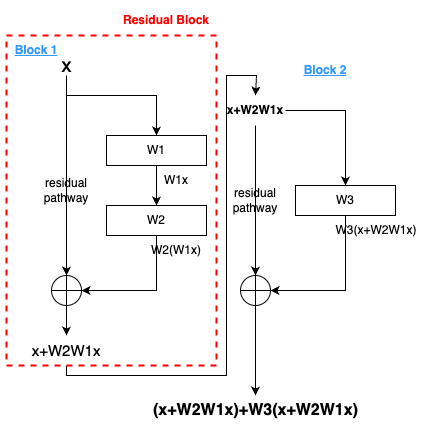

#### No-Residual Block Example
- $\hat{y} = W_3W_2W_1x$ (assume $b=0$)
- Loss: $L = f(\hat{y}, y)$
- $\frac{dL}{dW_3} = \frac{dL}{d\hat{y}}\cdot \frac{d\hat{y}}{dW_3} = \frac{dL}{d\hat{y}}(W_2W_1x)$
- $\frac{dL}{dW_2} = \frac{dL}{d\hat{y}}\cdot \frac{d\hat{y}}{dW_2} = \frac{dL}{d\hat{y}}(W_3W_1x)$
- $\frac{dL}{dW_1} = \frac{dL}{d\hat{y}}\cdot \frac{d\hat{y}}{dW_1} = \frac{dL}{d\hat{y}}(W_3W_2x)$

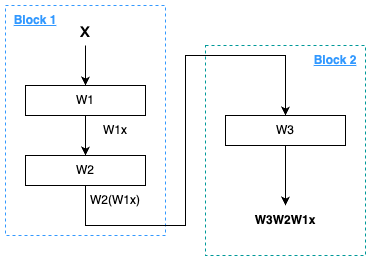

#### LayerNorm 一图胜千言
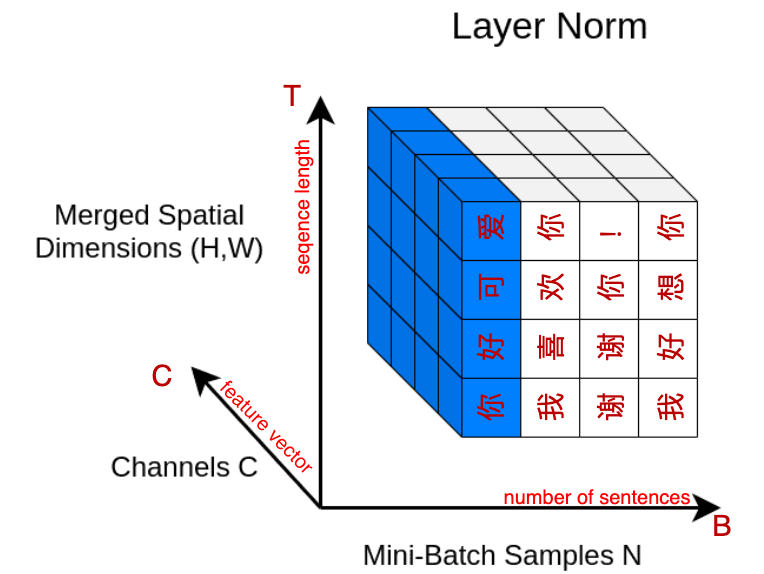

#### LayerNorm实现上的细微差别
LayerNorm实现上是右图, 但你的脑子里应该理解成左图！
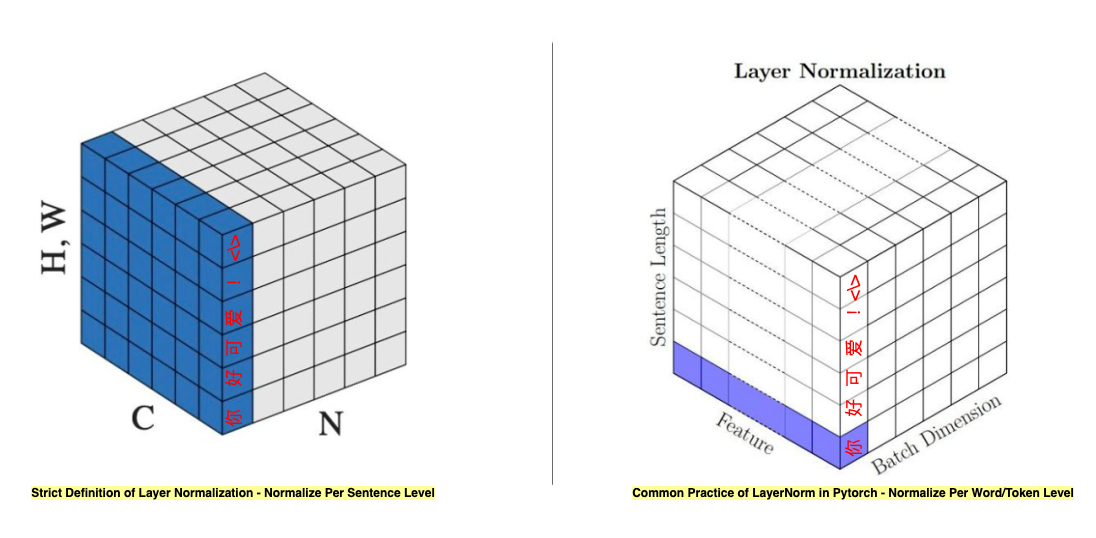

### Weight Update Recap
$W_{new} = W_{old} - lr\cdot \frac{dL}{dW_{old}}$
- $\frac{dL}{dW_{old}}$太小，$W_{new}$不更新。- vanishing gradient
- $\frac{dL}{dW_{old}}$太大，$W_{new}$变超大。- exploding gradient

### Weight Decay Recap
- L2 regularization to prevent overfitting: penalize a weight for being too large.
- $L_{new} = L + λ\sum_{i}W_{i}^2$
    - Adjust loss function to include extra regularization term $λ\sum_{i}W_{i}^2$.
    - $\lambda$: weight decay coefficient, a hyperparameter that controls the strength of the weight penalty.
- How it works?
    - Caluclate gradient: $\frac{dL_{new}}{dW_i} = \frac{dL}{dW_i} + λ2W_i$
    - Update weight: $W_i^{new} = W_i - η\frac{dL_{new}}{dW_i}$
    - As $\frac{dL}{dW_i}$ fixed, when $W_i \uparrow$, $\frac{dL_{new}}{dW_i} \uparrow$. Thus, $W_i^{new}$ reduces more.


### What is Dropout? Where to add? Why need it?
1. What is Dropout?
    - Regularization tool to prevent overfitting.
    - When adding dropout in a neural network, in every forward-backward pass, it randomly shuts off some subset of nodes (set them to 0 and train without them).
    - Because in each forward-backword pass, a subset is randomly chosen to shut off, it's like training an ensemble of sub-networks.
    - At test time, all nodes are fully enabled. It's like all sub-networks are merged into one single ensemble.
2. Where to add Dropout?
    1. Add dropout in **multi-head self-attention** layer and in **feed-forward** layer respectively. **General rule**: add dropout right before performing the addition for residual connection.
    2. Add dropout in **single self-attention head** right after softmaxed scaled `Q*K`.
3. Why need Dropout?
    - As we scale up out model, our neural network is getting deeper and deeper, which is prone to overfitting more easily.

### Why Normalization a good optimization for a very deep neural network?
- 观前提醒: 这里提及的“归一化”若无特意声明, 一律等同于“标准化”。i.e., $x \sim N(0,1)$
- 归一化的物理意义: 把data映射到原点周围。
- Why Good?
    1. 归一化不影响同一分布中样本与样本之间的可比性, 相对"距离/大小"是保留的。
        - LayerNorm: 不影响一个句子中词与词之间语义的可比性 (同一分布=同一个句子, 样本=词)
        - BatchNorm: 不影响不同图片间同一个feature的可比性 (同一分布=同一feature R/G/B, 样本="图片")
    2. Stabilize activations:
        - 啥是activation?
            - 简单理解: 每一层的输出output
            - 详细理解: 每一层/神经元经过线性变换, 然后又经过non-linearity变换的输出
        - 神经网络层与层之间的输出在量度scale和分布distrbution方面都可能天差地别 --> 归一化 --> 量度统一 + 分布stabilized
    3. Reduce **Internal Covariate Shift**:
        - 啥是internal covarivate shift (内部协变量漂移)?
            - 简单理解: 站在我前面的队伍都飘忽不定 (changes in the distribution of network activations)，那这让我怎么学啊 (slow down training process)，怎么能够安心下来学你给我指导的方向呢？归一化解决了这个问题: efficient training + less time to converge.
            - 详细理解: 在训练过程中，数据分布会发生变化，对接下来一层网络的学习带来困难。深度神经网络模型的训练为什么会很困难？其中一个重要的原因是，深度神经网络涉及到很多层的叠加，而每一层的参数更新会导致上层的输入数据分布发生变化，通过层层叠加，高层的输入分布变化会非常剧烈，这就使得高层需要不断去重新适应底层的参数更新。为了训好模型，我们需要非常谨慎地去设定学习率、初始化权重、以及尽可能细致的参数更新策略。
    4. Address Vanishing/Exploding Gradients:
        - 主要作用是在控制量度的统一。梯度爆炸/消失的主因就是连乘机制放大了其中某一个值过大/过小所造成的对全局的影响。归一化把所有值都拉回到同一个量度的水平，从而防止某个值出现过大或者过小。
- $γ$, $β$
    - Learnable (可通过训练求得的) Affine Transform (仿射变换) Parameters (参数)
    - $γ$: Scaling 缩放变换
    - $β$: Shifting 平移变换
    - Why need them?
        - 归一化是减去均值，单位化方差。这样训练更快，因为把数据集都映射到原点周围了。
        - 但是这样会导致后面**激活函数的表达能力变差**，归一化后的特征基本会被限制在正态分布下，降低了网络的表达能力，所以作者又引入了缩放和平移。
        - 所以加入缩放平移变量的原因就是：**保证每一次数据经过归一化后还保留原有学习来的特征，同时又能完成归一化操作，加速训练。这两个参数是用来学习的参数。**
        - TL;DR: 归一化把数据都带到统一标准，这样可能造成一些信息损失 (lose some of feature's unique qualities)，缩放平移在一定程度上弥补损失 (scaling and shifting maintain or enhance the feature's distinct qualities)
        - 比喻: 中学时期学校要求男生都圆寸, 女生都马尾。这种统一化标准使每个人都失去了特色。$γ$, $β$相当于是在还原每个人的特色: scaling调整发色深浅, shifting调整头发长度。
    - When need them?
        1. Network **very deep**: deeper, higher risk of losing info from normalization.
        2. Dataset **very complex**: complex pattern/distribution to learn
        3. **Fine-tune** a pre-trained model on new & different dataset

### Pytorch Recap
- `register_buffer()`:
    - A method used within `torch.nn.Module` classes.
    - Allows to register a tensor as a buffer within a module.
    - If a tensor is registered as a buffer:
        1. buffer is part of a module's state but do not get updated by gradients. (Other module's states are: Parameters, Module Hierarchy, Saving and Loading)
        2. it is useful for storing data that needs to persist across module invocations in a non-trainable manner.
        3. it automatically participates in device transfers (moving to GPU/CPU) and serialization (saving/loading).
- `torch.cat([t1, t2], dim=?)`: Concat tensors along specified dimension
    - Suppose `t_1 = t_2 = BxTxC`
    - `dim=0`: result = `(B+B)xTxC`
    - `dim=1`: result = `Bx(T+T)xC`
    - `dim=-1`: result = `BxTx(C+C)`
```python
tensor1 = torch.tensor([[1, 2, 3],
                        [4, 5, 6]])
tensor2 = torch.tensor([[7, 8, 9],
                        [10, 11, 12]])
torch.cat((tensor1, tensor2), dim=1) gives: 2x6
[[1,  2,  3,  7,  8,  9],
 [4,  5,  6, 10, 11, 12]])
```
- `nn.LayerNorm(normalized_shape)`: to declare a LayerNorm "layer"/function
    - [Pytorch document](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html)
- `torch.nn.Sequential(*arg)`: A PyTorch container module that sequences several modules (layers) together. When you input data into an nn.Sequential container, it passes the data through all the modules it contains in a sequential manner, from the first to the last, automatically handling the output to input transitions between these modules. 把放进去的层都串联起来。
    - Note: `nn.Sequential()` only takes modules one by one. Cannot take a list of modules.
    - Accept `nn.Sequential(Block(), Block())`
    - NOT accept `nn.Sequential([Block(), Block()])`
    - Therefore, if you are input a list, you need to unpack by using `*` (unpacking operator)
    - i.e. `nn.Sequential(*[Block(), Block()])` == `nn.Sequential(Block(), Block())`
- `*` Unpacking Operator:
    - `*[Block(),..., Block()] ==> Block(),..., Block()`

#### Pytorch LayerNorm Toy Example

In [ ]:
import torch
# NLP Example
# B, T, C = batch, sentence_length, embedding_dim
# 20个句子(B),每个句子长度/单词个数是5(T),每个单词抽成长度为10的vector(C)
B, T, C = 20, 5, 10
embedding = 10*torch.rand(B, T, C)
layer_norm = torch.nn.LayerNorm(normalized_shape=C) # 以词为单位, 独立地归一化。一个句子中词与词之间相互独立。
# 底层机制: [B, T, C] -transform-> [B*T, C] -LayerNorm-> [B*T, C] -restore-> [B, T, C]
# 一个句子中每个词的向量单独参与归一化。这个例子中一句话有5个词,每个词向量长度为10. 一次归一化参与的一共有10个值，一个句子分别进行相互独立的5次归一化.

# Activate module
x = layer_norm(embedding)

In [ ]:
# Inspect the distribution of each sentence (per b)
# Result: each sentence is normalized to mean 0, var 1 too
for b in range(B):
    print(f"sentence {b}: mean={x[b,:,:].mean()}; var={x[b,:,:].var()}")

sentence 0: mean=0.0; var=1.0204064846038818
sentence 1: mean=4.76837147544984e-09; var=1.0204066038131714
sentence 2: mean=-3.33786012163273e-08; var=1.0204066038131714
sentence 3: mean=9.53674295089968e-09; var=1.0204070806503296
sentence 4: mean=1.668930060816365e-08; var=1.02040696144104
sentence 5: mean=-3.33786012163273e-08; var=1.0204066038131714
sentence 6: mean=-9.53674295089968e-09; var=1.0204068422317505
sentence 7: mean=-1.2516975012033527e-08; var=1.0204066038131714
sentence 8: mean=-4.410743770222325e-08; var=1.0204063653945923
sentence 9: mean=1.4305114426349519e-08; var=1.0204061269760132
sentence 10: mean=-9.536743306171047e-08; var=1.0204061269760132
sentence 11: mean=-9.53674295089968e-09; var=1.0204070806503296
sentence 12: mean=5.364417887676609e-08; var=1.0204063653945923
sentence 13: mean=2.8610228852699038e-08; var=1.0204063653945923
sentence 14: mean=6.67572024326546e-08; var=1.020406723022461
sentence 15: mean=-5.2452087118126656e-08; var=1.0204068422317505
se

In [ ]:
# 单独看一个句子里每个单词各自的分布也是mean 0, var 1
for t in range(T):
    print(x[0,t,:].mean(), x[0,t,:].var()) # 第一个句子中每个单词各自的分布

tensor(9.5367e-08, grad_fn=<MeanBackward0>) tensor(1.1111, grad_fn=<VarBackward0>)
tensor(-7.1526e-08, grad_fn=<MeanBackward0>) tensor(1.1111, grad_fn=<VarBackward0>)
tensor(-7.3016e-08, grad_fn=<MeanBackward0>) tensor(1.1111, grad_fn=<VarBackward0>)
tensor(2.0266e-07, grad_fn=<MeanBackward0>) tensor(1.1111, grad_fn=<VarBackward0>)
tensor(1.1325e-07, grad_fn=<MeanBackward0>) tensor(1.1111, grad_fn=<VarBackward0>)


In [ ]:
# 这里, 我们严格遵守LayerNorm的定义: 以句子为单位进行Normalize. i.e. normalized_shape=[T, C]
B, T, C = 20, 5, 10
embedding = 10*torch.rand(B, T, C)
layer_norm = torch.nn.LayerNorm(normalized_shape=[T, C]) # 以句子为单位，句子中所有词的值放在一起做归一化。句与句之间相互独立,一个句子中词与词之间相互不独立
# 一个句子中所有词的向量共同参与归一化。这个例子中一句话有5个词,每个词向量长度为10. 一次归一化参与的一共有5x10=50个值

# Activate module
x = layer_norm(embedding)

In [ ]:
# 结果上来看和之前InstanceNorm没有什么区别，句子和词都归一化了
for b in range(B):
    print(f"sentence {b}: mean={x[b,:,:].mean()}; var={x[b,:,:].var()}")

sentence 0: mean=1.0609626599489275e-07; var=1.0204070806503296
sentence 1: mean=-9.059905892172537e-08; var=1.0204068422317505
sentence 2: mean=-9.53674295089968e-09; var=1.0204068422317505
sentence 3: mean=7.152557657263969e-08; var=1.02040696144104
sentence 4: mean=-5.4836274188119205e-08; var=1.020406723022461
sentence 5: mean=7.1525572131747595e-09; var=1.0204073190689087
sentence 6: mean=-1.0490417423625331e-07; var=1.0204070806503296
sentence 7: mean=2.4318694613612024e-07; var=1.0204066038131714
sentence 8: mean=-5.7220457705398076e-08; var=1.02040696144104
sentence 9: mean=4.5299529460862686e-08; var=1.02040696144104
sentence 10: mean=-1.0490417423625331e-07; var=1.02040696144104
sentence 11: mean=-5.4836274188119205e-08; var=1.02040696144104
sentence 12: mean=9.894370833762878e-08; var=1.0204068422317505
sentence 13: mean=1.4305114426349519e-08; var=1.0204068422317505
sentence 14: mean=-6.19888282926695e-08; var=1.02040696144104
sentence 15: mean=-7.98702259885431e-08; var=1.

In [ ]:
# 每个词归一后的分布稍微要差一些
for t in range(T):
    print(x[0,t,:].mean(), x[0,t,:].var()) # 第一个句子中每个单词各自的分布

tensor(-0.0985, grad_fn=<MeanBackward0>) tensor(0.9194, grad_fn=<VarBackward0>)
tensor(0.6792, grad_fn=<MeanBackward0>) tensor(0.8595, grad_fn=<VarBackward0>)
tensor(-0.2670, grad_fn=<MeanBackward0>) tensor(1.2255, grad_fn=<VarBackward0>)
tensor(-0.1813, grad_fn=<MeanBackward0>) tensor(1.1041, grad_fn=<VarBackward0>)
tensor(-0.1325, grad_fn=<MeanBackward0>) tensor(0.7885, grad_fn=<VarBackward0>)


## After Talk [1:42:31]
- What we've programmed so far is **decoder-only transformer**. No **cross-attention** block and no implementation of **encoder**.
- Why we have a **decoder-only transformer**?
    - Suitable for language modeling task.
    - That is, because our task is just to generate text and it's unconditioned on anything. In other words, given a training dataset (text corpus), our model is just learning and mimicking its pattern.
- What makes it **decoder**?
    - Essence: It has **upper-triangular masking mechanism** that gives autoregressive (只能回头看) property.
- **encoder-decoder** architecture:
    - Suitable for machine translation task.
    - Particularly, this architecture expects some tokens that encode French words, then it is expected to decode the translation in English.
    - Typically, the **encoder-decoder** model is expected to:
        1. Encode phase: read in a French sentence and condition on this sentence.
        2. Decode phase: start off the generation with a special token `<START>`. Then, the network is expected to output a corresponding English translation followed by a special token `<END>` to finish the generation.
    - The output English sentence will be decoded exactly as we've done in **decoder-only**. However, in **encoder-decoder**, there is an extra step: conditioning the generation on some additional info, which in this example is the French sentence to be translated. This extra step is why we bring in **encoder** that reads the French sentence and puts a transformer on it. Note! In encoder, we DON'T use upper-triangular masking! So, all past and future tokens are allowed to talk to each other as much as they want. Such a mechanism encodes whatever the content of this French sentence is. Once encoded, **encoder** outputs **K, V** to cross-attention block in **decoder** (**decoder** prepares its own **Q**). Thus, the cross-attention block basically means that the generation is conditioning the decoding NOT ONLY on the past of this current decoding (ie. decoded English words generated so far), BUT ALSO on having seen the fully encoded French prompt.
```
# French to English translation example:
<--------- ENCODE ------------------><--------------- DECODE ----------------->
les réseaux de neurones sont géniaux! <START> neural networks are awesome!<END>
```

## NanoGPT Walkthrough [1:46:24]
- `train.py`: boilerplate code for training the network. Basically, advanced `v2.py` with additional code for: 1. saving & loading checkpoints, pre-trained weights; 2. decaying the learning rate; 3. compiling the model; 4. using distributed training across multiple nodes/GPUs.
- `model.py`: almost identical to `v2.py`.
    - Difference 1: `v2.py` encapsulates/concatenates/groups `Head` in `MultiHeadAttention` while `model.py` merges # of heads into a dimension. i.e. `(B, T, C, n_head)` all are implemented in a batched manner inside a single `CausalSelfAttention`.
        - Namely, `K, Q, V = B x n_head x T x (C/n_head)`
    - Difference 2: replace ReLU with GeLU
    - Difference 3: checkpoints loading, separate out some weight decay.